# Tracking App featuring in App Store and Google Play 

###### 30/10/2022


![alt text](https://thumbs.dreamstime.com/b/app-store-games-collection-apple-ipad-air-kiev-ukraine-june-brand-new-modern-white-featured-mobile-apps-41828259.jpg)

## 1.Introduction 


Launching a game globally is not something you get to see often these days, the product has to go through lot before it qualifies to go globally, after launching globally everyone in the game team is interested to see how good is the game performing and how happy with the game are the two main stores, App store and google play. These stores have criteria that might be not always clear on how featuring happens, this criteria includes; optimal crash rates, live events and many other factors that we know and some that we don't know. In this notebook we will track featuring for imaginary game using artificial data and come out with results that will help us improve our product


## 2.Problem to solve 

Tracking of Featuring placements on the stores is usually done using external tools like App figures.com, these are usually helpful but not enough because

* **Difficulty in granting access to all team members, since usually these tools charge per specific users numbers**
* **Limited functionality and non-flexible charts/tables, in case of app figures you can't access the featuring data for custom periods other than what the website has**
* **Putting all the data of the product in the same place makes it easier to do analysis and come up with conclusions to take actions**


## 3.Methodology 

I will call Appfigures API using python script, this script will be scheduled to run daily. Then this data will be cleaned and wrangled and sent to BigQuery as table in dataset then this data will be visualised using data studio.

## Data Sources
In this notebook I'll be calling appfigures API for the purpose of showing code only NOT using the real data. The data that will be used in the visualization and analysis is 100% fake data that I personally made to mimic real product senario. 



## Data Cleaning 
Part of the data wrangling/cleaning will be done using Pandas library to map the data needed from the JSON file we get from AppFigures API, part of the data wrangling/cleaning will be done in BigQuery

## Visualization
Google data studio (Looker studio) will be used to build the dashboard after putting the data to BQ 


<br>
<br>




### Dependencies
downloading all dependencies required




In [5]:
# Demonstrates using the rauth library to interact with the Appfigures API
from rauth import OAuth1Session, OAuth1Service

# Library to handle JSON files
import json

#Data structure library in Python
import pandas as pd
from datetime import date ,timedelta
import pandas_gbq
import os
from google.cloud import bigquery
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
print("imported!!")

imported!!



#  Calling AppFigures API for 1 app per call


Access the API documentation from [here](https://docs.appfigures.com/api/reference/v2/featured)
<br>
There are 4 types of reports
1. Summary reports
2. Full featured reports 
3. Counts reports count 
4. History reports

For the purpose of this project we will be using the Full report, which should be done separately for each App so Apple and google play separate.


### Getting today's date that will be inserted in the GET request 

In [4]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-11-01


In [ ]:




base_url = "https://api.appfigures.com/v2"
client_key = "############"
client_secret = "############"


request_token_url = base_url + "/oauth/request_token"
authorize_url = base_url + "/oauth/authorize"
access_token_url = base_url + "/oauth/access_token"

def get_service():
  """ Returns an OAuthService configured for us """
  return OAuth1Service(name="appfigures",
                        consumer_key=client_key,
                        consumer_secret=client_secret,
                        request_token_url=request_token_url,
                        access_token_url=access_token_url,
                        authorize_url=authorize_url,
                        base_url=base_url)


def get_session(access_token=None, access_token_secret=None):
  """If access_token and secret are given, create and return a session.

      If they are not given, go through the authorization process
      interactively and return the new session
  """
  oauth = get_service()

  if access_token:
    session = OAuth1Session(client_key, client_secret,
                            access_token, access_token_secret,
                            service=oauth)
    return session

  params = {"oauth_callback": "oob"}
  headers = {'X-OAuth-Scope': 'public:read,products:read'}
  request_token, request_token_secret = oauth.get_request_token(
                                          params=params,
                                          headers=headers
                                        )

  authorization_url = oauth.get_authorize_url(request_token)
  print("Go here: %s to get your verification token."
          % authorization_url)
  verifier = input("Paste verifier here: ")
  session =  oauth.get_auth_session(request_token, 
                                    request_token_secret,
                                    "POST",
                                    data={"oauth_verifier":verifier})
  return session


if __name__ == "__main__":
  s = get_session("############", "############")
  print("Access Token: %s\tAccess Secret:%s"
          % (s.access_token, s.access_token_secret))
  resp = s.get(base_url + f"/featured/full/#########/{today}/{today}")
  print(resp.json())
    # print([ product['name'] for (id, product) in resp.json().items()])

  # it is VERY important that querystring parameters go in params
  # rather than directly put in the URL. rauth will not sign the request
  # correctly if you did s.get(base_url+"products/mine?store=apple")

  

# JSON file result from the API call 

#### This is an example result of the call 
[![Screenshot 2022-11-01 152120](https://i.im.ge/2022/11/07/24Zi08.Screenshot-2022-11-01-152120.png)](https://im.ge/i/24Zi08)

## Mapping the JSON file and building the dataframe with pandas

Picking the fields we are interested in and mapping it to the column names assigned then building the data frame 

In [ ]:
x=resp.json()
df = pd.DataFrame(map(lambda kv: {
    'feature_id': kv[0],
    **kv[1]['base_category'],
    'viewed_from': kv[1]['viewed_from'],
     'crumbs': kv[1]['crumbs'],
     'highest_position': kv[1]['highest_position'],
     'lowest_position': kv[1]['lowest_position'],
'country': kv[1]['country'],
    'start_date': kv[1]['start_date'],
    'end_date': kv[1]['end_date'],
}, x.items()))
df


#### This is an example result of data frame result from the mapping above

Notice that highest_position and lowest_position are always the same since we are pulling the data on a daily basis. And the position does NOT change within the same date


 ***This data is completely fake data***

![alt text](https://i.postimg.cc/QMdG7xms/Screenshot-2022-11-01-160335.png)

## Mapping the JSON file and building the dataframe with pandas
#### Defining Google BigQuery Credentials, project and table id where the data will be append 

In [607]:
credentials_path = r"C:\Users\########.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path
client = bigquery.Client(project='newwww-339715')
table_id= 'newwww-339715.featuring.raw'

job_config = bigquery.LoadJobConfig()
job_config.write_disposition = 'WRITE_APPEND'
job_config.autodetect = True
job_config.ignore_unknown_values = True
job = client.load_table_from_dataframe(result, table_id,job_config =job_config)


## The result RAW table in BQ 

### The result RAW table will look like this 
[![Screenshot 2022-11-06 165016](https://i.im.ge/2022/11/07/24ZPNq.Screenshot-2022-11-06-165016.png)](https://im.ge/i/24ZPNq)

## Cleaning the data and prepare it for visualising 

### The raw data extracted from  Appfigures API will be cleaned using the following query in BQ. This query will do mainly the following 


* Concat the needed columns to build each distinct featuring,using concat function 
* Remove any not needed special characters/words from the columns, using REGEXP_REPLACE function
* assign the device types and stores with suitable names 

In [ ]:
""""
create table featuring.cleaned as (SELECT
   platform,
  position,
  date,
  country,
    REGEXP_REPLACE(REGEXP_REPLACE(Featuring, r'\((.*?)\)',''),'Today ,','') as Featuring

FROM (
  SELECT
     *,
    CONCAT(device,' ',category,' ',sub_category) Featuring
  FROM (
    SELECT
       platform,
      position,
      date,
      country,
      category,
      device,
      sub_category
    FROM (
      SELECT
        CASE store
          WHEN 'google_play' THEN 'android'
          WHEN 'apple' THEN 'ios'
        ELSE
        'other'
      END
        AS Platform,
        name AS category,
        highest_position AS position,
        date,
        country,
        CASE
          WHEN device = 'handheld' THEN 'phone'
        ELSE
        device
      END
        device,
        CASE
          WHEN crumbs LIKE '%UPDATED%' THEN LOWER(LTRIM (REGEXP_EXTRACT(regexp_extract(crumbs, r' -.*'), r'-(.*)')))
        ELSE
        crumbs
      END
        sub_category
      FROM
        `newwww-339715.featuring.raw`))))
""""

## The result Cleaned table in BQ 

### The result Cleaned table will look like this 
[![Cleaned](https://i.im.ge/2022/11/07/24ZtVp.Cleaned.png)](https://im.ge/i/24ZtVp)

### In real-life practice, we can schedule the query daily in GCP and append the original table, for this notebook creating the table once will be enough


## Visualising the data using Looker studio 

### Access the full report from [here](https://datastudio.google.com/reporting/3c4d25a0-802b-4bd4-9640-c820573b3775)

[![report](https://i.im.ge/2022/11/07/24KYWX.report.png)](https://im.ge/i/24KYWX)


# Analysis and Results 

* For the period between **26th April 2021 - 27th May 2021**, the app got featured **25.6K** in total of days and feature placments in **174** different countries in **93** distinct featuring placments.


### Crash rate and total featuring 
We see negative correlation between total featuring placements and crash rate especially on iOS, the days the app had high crash rates, we see decrease in featuring total numbers.


[![Featuring](https://i.im.ge/2022/11/09/SQfRXz.Featuring.png)](https://im.ge/i/SQfRXz)
[![Crashed](https://i.im.ge/2022/11/09/SQfZcF.Crashed.png)](https://im.ge/i/SQfZcF)



### Installs, IAP revenue and total featuring 
* We assume that we have steady spend on UA on the whole period and factors other than featuring is stable.
* We see an expected strong positive correlation between total featuring placements, installs and IAP revenue 

[![Featuring](https://i.im.ge/2022/11/09/SQfRXz.Featuring.png)](https://im.ge/i/SQfRXz)
[![installs](https://i.im.ge/2022/11/09/SQfKGK.installs.png)](https://im.ge/i/SQfKGK)
[![NET Revenue](https://i.im.ge/2022/11/09/SQff79.NET-Revenue.png)](https://im.ge/i/SQff79)

### Feature placement position  and installs correlation 

For this metric, we will look at the average feature placement position and the correlation with the installs  

### Dependencies

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

**Reading CSV file that has AVG featuring position and installs number by date**

In [3]:
df=pd.read_csv(r'C:\Users\jamit\Downloads\Full.csv')
df.head()
df

,date,position,installs
0,26/04/2021,13.544643,41216
1,27/04/2021,9.767176,60260
2,28/04/2021,10.319249,58788
3,29/04/2021,10.322368,62928
4,30/04/2021,10.526786,56672
5,01/05/2021,12.129779,45724
6,02/05/2021,12.022388,49312
7,03/05/2021,3.623002,80592
8,04/05/2021,3.507480,116840
9,05/05/2021,3.776846,109664


## Plotting installs number vs AVG featuring position using replot from seaborn library 

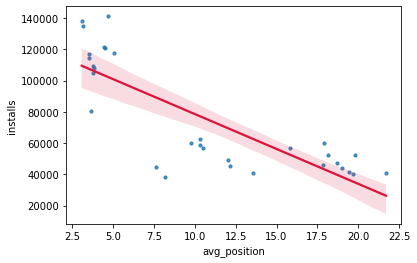

In [12]:
viz_1=sns.regplot(x="position",y="installs",data=df,line_kws={'color': 'crimson'}, scatter_kws={'s' : 10})
viz_1.set(xlabel='avg_position', ylabel='installs')

plt.show(viz_1)

## Calculating Pearson correlation coefficient


In [10]:
correlation = df["position"].corr(df["installs"],method ='pearson')
print(correlation)

-0.8126677954403058


* **We see a strong correlation between the number of installs and the featuring position**
* **Obligatory call-out: correlation ≠ causation**
* **Next we will calculate the slope to gives us the  direction and steepness of the trend line, using linregress from scipy library.**



In [9]:
from scipy.stats import linregress
linregress(df["position"],df["installs"],)

LinregressResult(slope=-4462.141517108157, intercept=123285.76051784476, rvalue=-0.8126677954403058, pvalue=2.809539328015259e-08, stderr=594.150712960209, intercept_stderr=7370.383107838095)

* **From the slope we got we can see that we get less 4462 installs for every 1 increase in featuring position**


## Future Directions 

* Trying to keep crash rates as low as possible since it plays clear role in the app getting featured. 
* Work on increase liveOps e.g. live events in Halloween and chrisrmats periods with enough support for the stores assets from the marketing artists.
* Aiming to be in high positions when featured since we see a strong correlation between the position of the featuring and the number of installs we are getting. 
* Keep featuring in mind when tracking any other changes we make in the game.

## Conclusion

In this notebook, I showed case of an efficient solution for a real issue in the gaming industry that will make tracking your game more easy and will give you more clear insight about how your game is performing with daily updated data. This aspect of the product doesn't usually get the enough attention while its still pretty important. 